In [ ]:
# Cell 1: Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import os
import time # To time the calibration

# Add the 'src' folder to the path
sys.path.insert(0, os.path.abspath('../src'))

# --- Import our tools ---
from data_fetcher.yfinance_fetcher import fetch_data
from calibration.gbm_calibrator import GbmCalibrator
from calibration.merton_calibrator import MertonCalibrator 

from models.gbm import GeometricBrownianMotion
from models.merton import MertonJumpDiffusion

# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')
print("All modules imported successfully.")

All modules imported successfully.


/media/harsh-vardhan-gupta/New Volume/Placement Prep/BTP/src/data_fetcher/yfinance_fetcher.py:22: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

Fetching GOLDBEES.NS data from 2022-01-01 to 2024-12-31...
Data fetched successfully. 738 data points.


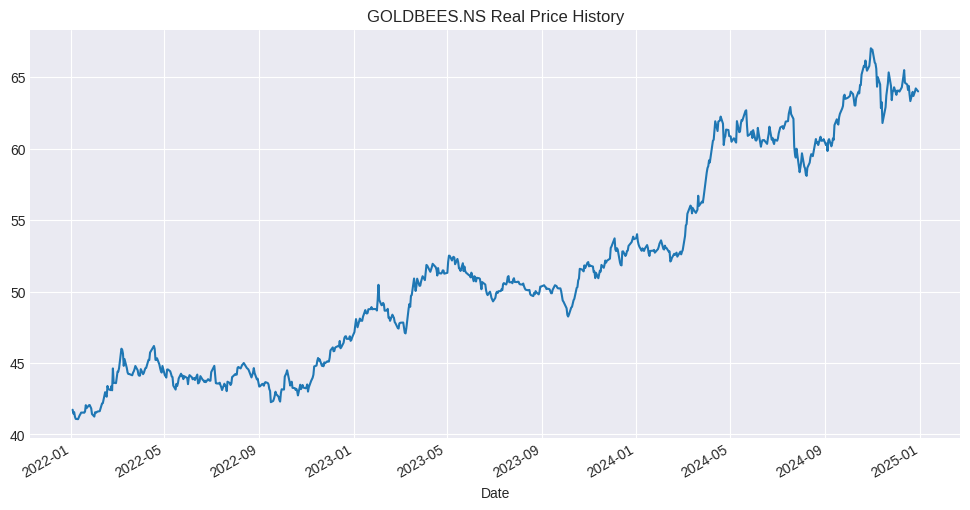

--- 1. Calibrating GBM (Baseline) ---
GBM calibration finished in 0.00 seconds.
GBM AIC: -5117.55
GBM Params: {'mu': np.float64(0.15331685036747497), 'sigma': np.float64(0.11905887384288402), 'S0': np.float64(41.72999954223633)}

--- 2. Calibrating Merton (Challenger) ---
NOTE: This may take 30-60 seconds...
Merton calibration finished in 0.19 seconds.
Merton AIC: -5180.77
Merton Params: {'mu': np.float64(0.1532517915307845), 'sigma': np.float64(0.07434746354945893), 'lambda_j': np.float64(118.18784986023604), 'mu_j': np.float64(0.0002561816862116702), 'sigma_j': np.float64(0.008545494872991312), 'S0': np.float64(41.72999954223633)}

--- 3. Final Model Comparison ---
        Log-Likelihood  # Params          AIC          BIC
Merton     2595.384070         5 -5180.768139 -5157.755200
GBM        2560.774014         2 -5117.548028 -5108.342852

--- Conclusion ---
🏆 The Merton model (AIC: -5180.77) is the WINNER!
Its score is lower than GBM (AIC: -5117.55).
This suggests the data *does* co

In [ ]:
# Cell 2: Fetch Real Data
ticker = 'GOLDBEES.NS' # Nippon India ETF Gold BeES
start = '2022-01-01'
end = '2024-12-31' 

print(f"Fetching {ticker} data from {start} to {end}...")
real_data = fetch_data(ticker, start, end)[ticker]

# Make sure data fetching worked
assert real_data is not None, "Data fetching failed! Check ticker or internet."
assert not real_data.empty, "Data is empty!"

print(f"Data fetched successfully. {len(real_data)} data points.")
real_data.plot(title=f"{ticker} Real Price History", figsize=(12, 6))
plt.show()

# Cell 3: Calibrate Model 1 (GBM - The Baseline)
print("--- 1. Calibrating GBM (Baseline) ---")
start_time_gbm = time.time()

# Create the calibrator (using 1/252 for daily data)
gbm_cal = GbmCalibrator(dt=1/252)

# Fit the model to the data
gbm_cal.fit(real_data)

end_time_gbm = time.time()

print(f"GBM calibration finished in {end_time_gbm - start_time_gbm:.2f} seconds.")
print(f"GBM AIC: {gbm_cal.get_aic():.2f}")
print(f"GBM Params: {gbm_cal.get_params()}")

# Cell 4: Calibrate Model 2 (Merton - The Challenger)
print("\n--- 2. Calibrating Merton (Challenger) ---")
print("NOTE: This may take 30-60 seconds...")
start_time_merton = time.time()

# Create the calibrator
merton_cal = MertonCalibrator(dt=1/252)

# Fit the model (with error handling)
try:
    merton_cal.fit(real_data)
    end_time_merton = time.time()
    print(f"Merton calibration finished in {end_time_merton - start_time_merton:.2f} seconds.")
    print(f"Merton AIC: {merton_cal.get_aic():.2f}")
    print(f"Merton Params: {merton_cal.get_params()}")
    merton_succeeded = True
except Exception as e:
    print(f"!!! MERTON CALIBRATION FAILED !!!")
    print(f"Error: {e}")
    merton_succeeded = False

# Cell 5: The Final Result - Model Comparison
print("\n--- 3. Final Model Comparison ---")

if not merton_succeeded:
    print("Cannot compare models, Merton calibration failed.")
else:
    # Build a comparison table
    results = {
        'Log-Likelihood': [
            gbm_cal.get_log_likelihood(),
            merton_cal.get_log_likelihood()
        ],
        '# Params': [
            gbm_cal.n_params,
            merton_cal.n_params
        ],
        'AIC': [
            gbm_cal.get_aic(),
            merton_cal.get_aic()
        ],
        'BIC': [
            gbm_cal.get_bic(),
            merton_cal.get_bic()
        ]
    }
    
    # Create the DataFrame
    results_df = pd.DataFrame(results, index=['GBM', 'Merton'])
    
    # Print the results, sorted by AIC (lowest is best)
    print(results_df.sort_values(by='AIC'))
    
    print("\n--- Conclusion ---")
    aic_gbm = gbm_cal.get_aic()
    aic_merton = merton_cal.get_aic()
    
    if aic_merton < aic_gbm:
        print(f"🏆 The Merton model (AIC: {aic_merton:.2f}) is the WINNER!")
        print(f"Its score is lower than GBM (AIC: {aic_gbm:.2f}).")
        print("This suggests the data *does* contain jumps ('fat tails')")
        print("and the extra 3 parameters were justified.")
    else:
        print(f"🏆 The GBM model (AIC: {aic_gbm:.2f}) is the WINNER!")
        print(f"Its score is lower than Merton (AIC: {aic_merton:.2f}).")
        print("This suggests the Merton model was 'overfitting'.")
        print("The extra complexity was not worth it for this dataset.")


--- 4. Plotting Calibrated Simulations ---
Simulating 1 paths for each model...


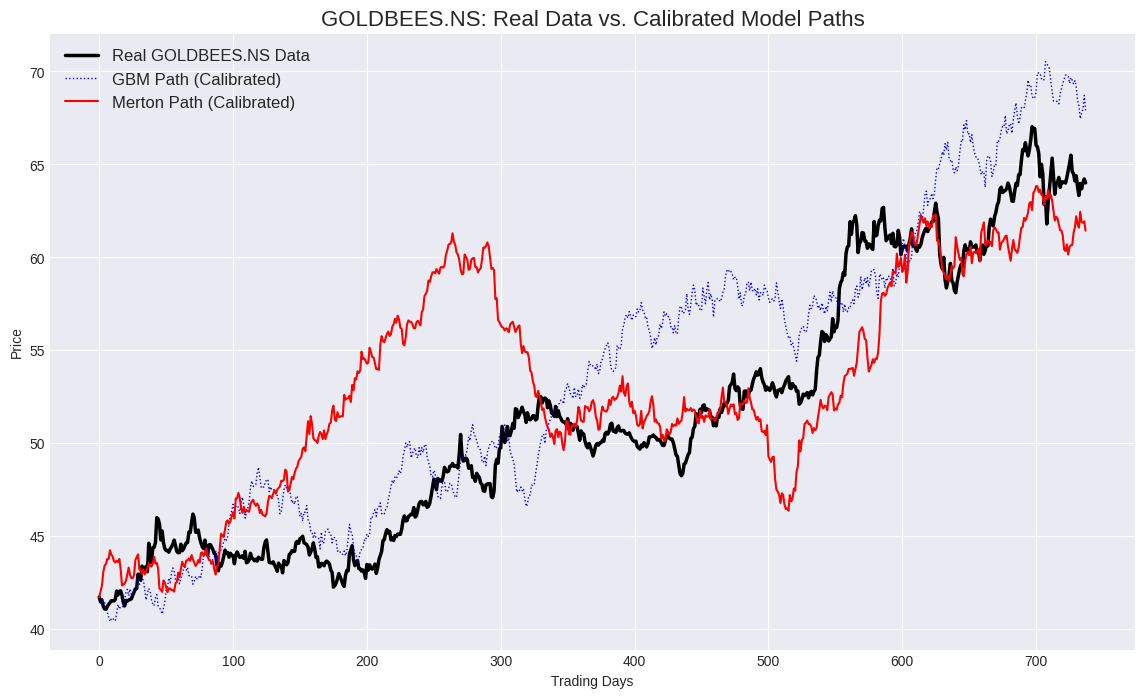

In [ ]:
# Cell 6: Plot Calibrated Simulations
print("\n--- 4. Plotting Calibrated Simulations ---")

# 1. Get the calibrated parameters from our objects
params_gbm = gbm_cal.get_params()
params_merton = merton_cal.get_params()

# 2. Get the simulation time horizon from the data
T = (gbm_cal.n_obs) * gbm_cal.dt # (e.g., 730 obs * 1/252 dt)
dt = gbm_cal.dt
n_paths_to_plot = 1

# 3. Instantiate the models with the REAL parameters
model_gbm_calibrated = GeometricBrownianMotion(**params_gbm)
model_merton_calibrated = MertonJumpDiffusion(**params_merton)

# 4. Run new simulations
print(f"Simulating {n_paths_to_plot} paths for each model...")
paths_gbm = model_gbm_calibrated.simulate(T, dt, n_paths_to_plot)
paths_merton = model_merton_calibrated.simulate(T, dt, n_paths_to_plot)

# 5. Plot everything together
plt.figure(figsize=(14, 8))

# Plot the real data
# We need to reset the index to match the 0-based sim
real_data_plot = real_data.reset_index(drop=True)
plt.plot(
    real_data_plot, 
    color='black', 
    linewidth=2.5, 
    label=f"Real {ticker} Data"
)

# Plot the GBM paths
plt.plot(
    paths_gbm, 
    color='blue', 
    linestyle = 'dotted',
    linewidth=1.0,
    label="GBM Path (Calibrated)"
)

# Plot the Merton paths
plt.plot(
    paths_merton, 
    color='red', 
    linewidth=1.5,
    label="Merton Path (Calibrated)"
)

plt.title(f"{ticker}: Real Data vs. Calibrated Model Paths", fontsize=16)
plt.xlabel("Trading Days")
plt.ylabel("Price")

# Clean up the legend (to avoid duplicate labels)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), fontsize=12)

plt.show()